In [1]:

from decouple import config
import pandas
from core.DataGetter import AsyncRequest
from core.SQLeto import SQLeto
import sqlalchemy as sql
import matplotlib.pyplot as plt
import DataHandler
data_handler = DataHandler.DataHandler()
%load_ext sql

### REQUISIÇÃO E ORGANIZAÇÃO DOS DADOS

### Requesting data from dadosabertos portal.

In [2]:
data_getter = AsyncRequest()
url = f"https://dadosabertos.aneel.gov.br/api/3/action/datastore_search?resource_id=b1bd71e7-d0ad-4214-9053-cbd58e9564a7&limit=35000"
raw_data = await data_getter.get(url)

#### Treating data and organizing it.

In [3]:
raw_data_df = pandas.DataFrame.from_dict(raw_data.json()['result']['records'])

#### Loading data to DB.

In [4]:
RAW_DATA = config('RAW_DATA_PATH')
DATABASE_POSTGRES = config('DATABASE_POSTGRES')
PWD_POSTGRES = config('PWD_POSTGRES')
USER_POSTGRES = config('USER_POSTGRES')

In [5]:
data_getter = SQLeto(DATABASE_POSTGRES, USER_POSTGRES, PWD_POSTGRES)
# data_handler.upload_dataframe_to_db(table_name='ger_dist',dataframe=raw_data_df, if_exists_="replace")

In [6]:
%sql postgresql://root:secret@db:5432/my_db

#### Save data as json, and csv

In [7]:
%%sql
SELECT * FROM ger_dist LIMIT 5

 * postgresql://root:***@db:5432/my_db
5 rows affected.


_id,DatGeracaoConjuntoDados,AnmPeriodoReferencia,NumCNPJDistribuidora,SigAgente,NomAgente,CodClasseConsumo,DscClasseConsumo,CodSubGrupoTarifario,DscSubGrupoTarifario,codUFibge,SigUF,codRegiao,NomRegiao,CodMunicipioIbge,NomMunicipio,CodCEP,SigTipoConsumidor,NumCPFCNPJ,NomeTitularEmpreendimento,CodEmpreendimento,DthAtualizaCadastralEmpreend,SigModalidadeEmpreendimento,DscModalidadeHabilitado,QtdUCRecebeCredito,SigTipoGeracao,DscFonteGeracao,DscPorte,MdaPotenciaInstaladaKW,NumCoordNEmpreendimento,NumCoordEEmpreendimento,NomSubEstacao,NumCoordESub,NumCoordNSub
1,2023-03-05,03/2023,33050196000188,CPFL-PAULISTA,COMPANHIA PAULISTA DE FORÇA E LUZ,1,Residencial,9,B1,35,SP,3501,Sudeste,3533007,Nova Granada,15440***,PF,***.497.808-**,***,None,2023-01-23,P,Com Microgeracao ou Minigeracao distribuida,1,UFV,Radiação solar,Microgeracao,"3,30",None,None,None,None,None
2,2023-03-05,03/2023,04065033000170,ELETROACRE,ENERGISA ACRE - DISTRIBUIDORA DE ENERGIA S.A,2,Comercial,11,B3,12,AC,1202,Norte,1200401,Rio Branco,69912452,PJ,12005360000165,ELITE ENGENHARIA LTDA,GD.AC.000.000.590,2015-07-15,P,Com Microgeracao ou Minigeracao distribuida,1,UFV,Radiação solar,Microgeracao,"32,50","-67,85","-9,96",None,None,None
3,2023-03-05,03/2023,04065033000170,ELETROACRE,ENERGISA ACRE - DISTRIBUIDORA DE ENERGIA S.A,1,Residencial,9,B1,12,AC,1201,Norte,1200609,Tarauacá,69970***,PF,***.582.542-**,***,GD.AC.000.000.591,2015-04-20,P,Com Microgeracao ou Minigeracao distribuida,1,UFV,Radiação solar,Microgeracao,"4,00","-70,78","-8,15",None,None,None
4,2023-03-05,03/2023,04065033000170,ELETROACRE,ENERGISA ACRE - DISTRIBUIDORA DE ENERGIA S.A,2,Comercial,11,B3,12,AC,1202,Norte,1200401,Rio Branco,69900273,PJ,05458883000100,ADVOCACIA PALÁCIO DANTAS,GD.AC.000.001.540,2015-06-22,P,Com Microgeracao ou Minigeracao distribuida,1,UFV,Radiação solar,Microgeracao,"2,00",None,None,None,None,None
5,2023-03-05,03/2023,04065033000170,ELETROACRE,ENERGISA ACRE - DISTRIBUIDORA DE ENERGIA S.A,1,Residencial,9,B1,12,AC,1202,Norte,1200401,Rio Branco,69919***,PF,***.754.418-**,***,GD.AC.000.001.552,2016-08-25,P,Com Microgeracao ou Minigeracao distribuida,1,UFV,Radiação solar,Microgeracao,"2,00","-67,86","-9,95",None,None,None


In [8]:
data = data_getter.execute_DQL(query='SELECT * FROM ger_dist', index_col='_id')
data.to_csv("/usr/src/app/app/data/gen_dist.csv")
data.to_json("/usr/src/app/app/data/gen_dist.json")

#### Aggregating data:

In [9]:
# Selecting only relevant columns.
monthly_df = data[['DatGeracaoConjuntoDados','AnmPeriodoReferencia','DscClasseConsumo', 'MdaPotenciaInstaladaKW', 'SigUF']]
monthly_df['MdaPotenciaInstaladaKW'] = monthly_df['MdaPotenciaInstaladaKW'].str.replace(',','.').astype('float')
monthly_df.head(5)

/tmp/ipykernel_11696/3008450873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_df['MdaPotenciaInstaladaKW'] = monthly_df['MdaPotenciaInstaladaKW'].str.replace(',','.').astype('float')


,DatGeracaoConjuntoDados,AnmPeriodoReferencia,DscClasseConsumo,MdaPotenciaInstaladaKW,SigUF
_id,,,,,
1,2023-03-05,03/2023,Residencial,3.3,SP
2,2023-03-05,03/2023,Comercial,32.5,AC
3,2023-03-05,03/2023,Residencial,4.0,AC
4,2023-03-05,03/2023,Comercial,2.0,AC
5,2023-03-05,03/2023,Residencial,2.0,AC


In [10]:
monthly_df.dtypes

DatGeracaoConjuntoDados     object
AnmPeriodoReferencia        object
DscClasseConsumo            object
MdaPotenciaInstaladaKW     float64
SigUF                       object
dtype: object

#### Total de empreendimentos por classe (Residencial, comercial, “...”) e estado federativo; 

In [11]:
result_emp_por_class = monthly_df[['DscClasseConsumo','SigUF','DatGeracaoConjuntoDados']].groupby(['DscClasseConsumo','SigUF']).count()
result_emp_por_class.rename(columns={'DatGeracaoConjuntoDados': "Número de empreendimentos"}, inplace=True)
file_name = "empreendimentos_por_classe"
#saving data
result_emp_por_class.to_csv(f"/usr/src/app/app/data/{file_name}.csv")
result_emp_por_class.to_json(f"/usr/src/app/app/data/{file_name}.json")
# add data to db
data_getter.upload_dataframe_to_db(table_name='empreendimentos_por_classe',dataframe=result_emp_por_class, if_exists_="replace")
result_emp_por_class

Saving table empreendimentos_por_classe
Table empreendimentos_por_classe saved!


Número de empreendimentos
DscClasseConsumo   SigUF                           
Comercial          AC                           508
                   AL                          2484
                   AM                           976
                   AP                           207
                   BA                           502
Iluminação pública BA                             1
Industrial         AC                            16
                   AL                           121
                   AM                            67
                   AP                             3
                   BA                            40
Poder Público      AC                            10
                   AL                            70
                   AM                            16
                   AP                            21
                   BA                            19
Residencial        AC                          3212
                   AL                         14056
                   AM                          5582
                   AP                          1973
                   BA                          1439
                   SP                             1
Rural              AC                           187
                   AL                           382
                   AM                            46
                   AP                             2
                   BA                            52
Serviço Público    AC                             1
                   AL                             2
                   AP                             1
                   BA                             2

#### Potência instalada de cada estado;

In [12]:
uf = monthly_df['SigUF'].unique()

result_list = []
for each_uf in uf:
    temp = monthly_df[monthly_df['SigUF'] == each_uf]
    result = pandas.DataFrame({'UF':[each_uf],'Pot inst (KW)':temp['MdaPotenciaInstaladaKW'].sum()})
    result_list.append(result)

result_pot_inst = pandas.concat(result_list, ignore_index=True)
result_pot_inst.dropna(inplace=True)
file_name = "pot_instalada_por_estado"
#saving data
result_pot_inst.to_csv(f"/usr/src/app/app/data/{file_name}.csv")
result_pot_inst.to_json(f"/usr/src/app/app/data/{file_name}.json")
# add data to db
data_getter.upload_dataframe_to_db(table_name='pot_inst',dataframe=result_pot_inst, if_exists_="replace")
result_pot_inst

Saving table pot_inst
Table pot_inst saved!


,UF,Pot inst (KW)
0,SP,3.30
1,AC,44205.28
2,AM,104713.30
3,AL,187540.95
5,AP,26899.99
6,BA,22298.47


### EXPOSIÇÃO DOS DADOS EM FORMA GRÁFICA

#### Número de Empreendimentos por estado por mes e tipo.

In [13]:
df2=data[['DthAtualizaCadastralEmpreend','SigUF','DscClasseConsumo','DatGeracaoConjuntoDados']].copy()
df2.dropna(inplace=True)
uf_list = df2['SigUF'].unique()
consume_class_list = df2['DscClasseConsumo'].unique()
result_list = []
for uf in uf_list:
    for consume_class in consume_class_list:
       temp_df=df2[(df2['SigUF']==uf)&(df2['DscClasseConsumo']==consume_class)]
       if (len(temp_df)==0):
           pass
       else:
        grouped=temp_df.groupby(['DscClasseConsumo','SigUF','DthAtualizaCadastralEmpreend']).count()
        result_list.append(data_handler.agg_time_data(grouped))
df3 = pandas.concat(result_list)
df3.drop(columns=['count'], inplace=True)
df3.sort_values(by='data', inplace=True)
df3['data'] = pandas.to_datetime(df3['data'], format='%Y-%m-%d')


In [14]:
import seaborn as sns

Text(0.5, 0.98, 'Número de Empreendimentos por estado por mes e tipo.')

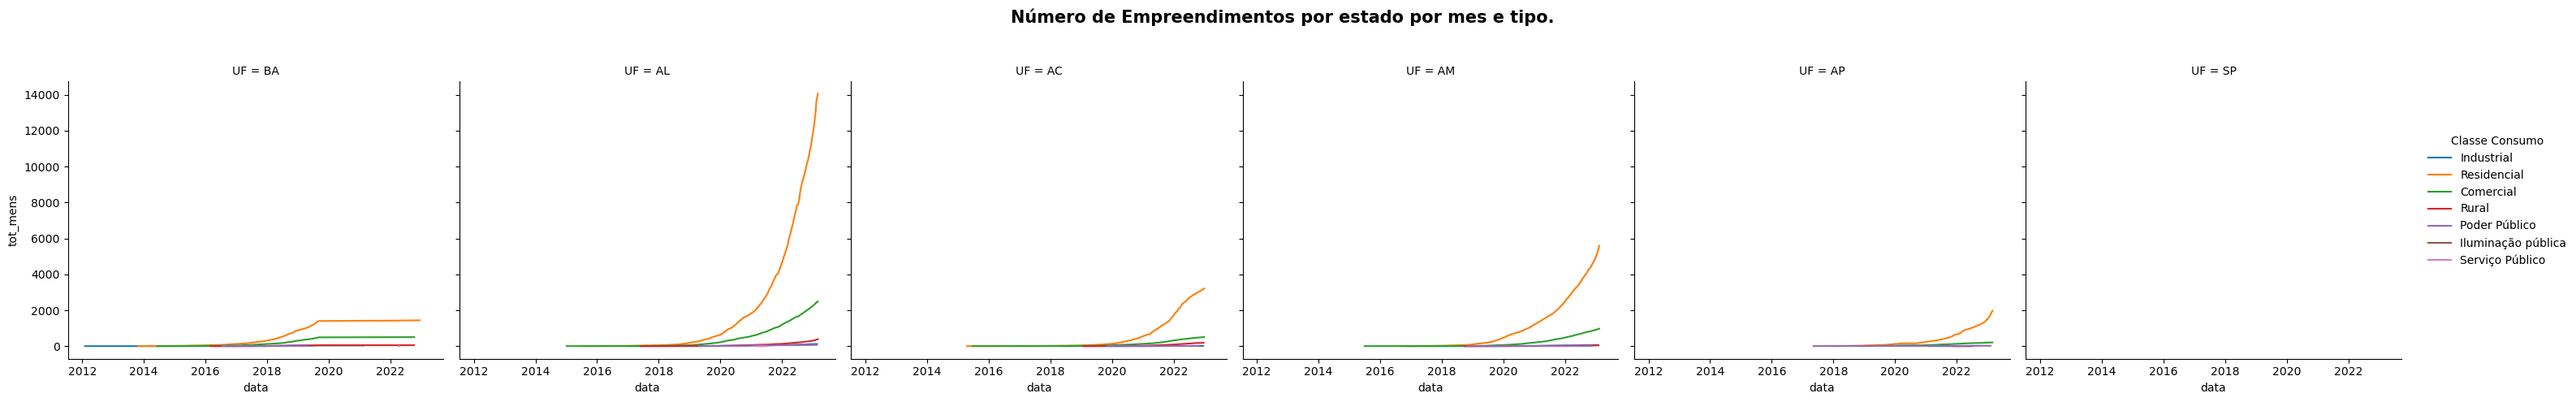

In [15]:
grid = sns.FacetGrid(df3, col='UF', hue='Classe Consumo', height=5)
grid.map_dataframe(sns.lineplot, x='data', y="tot_mens")
grid.add_legend()
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle("Número de Empreendimentos por estado por mes e tipo.", fontweight="bold", fontsize=15)


Text(0.5, 0.98, 'Número de Empreendimentos por estado por mes e tipo.(Detalhamento)')

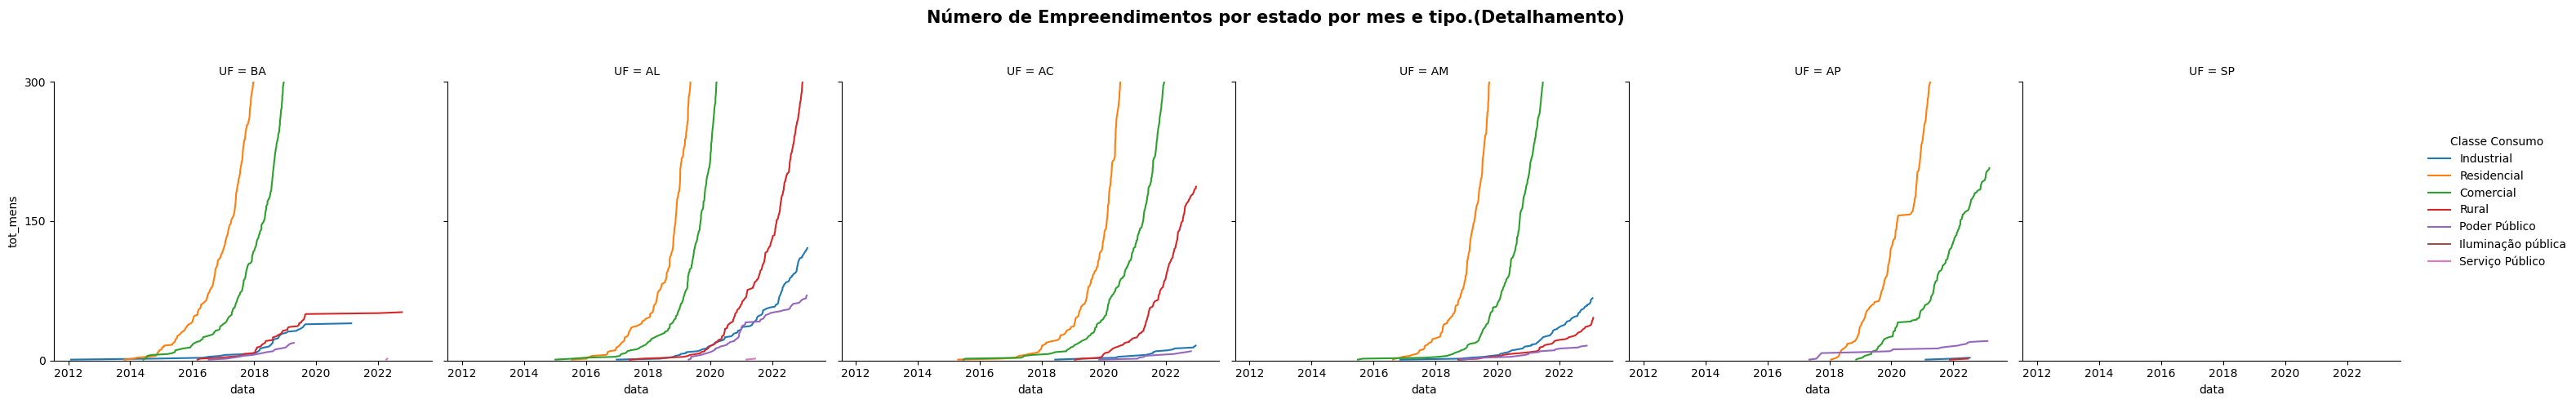

In [16]:
grid = sns.FacetGrid(df3, col='UF', hue='Classe Consumo', height=5)
grid.map_dataframe(sns.lineplot, x='data', y="tot_mens")
grid.add_legend()
grid.set(ylim=(0, 300), yticks=[0,150,300])
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle("Número de Empreendimentos por estado por mes e tipo.(Detalhamento)", fontweight="bold", fontsize=15)

#### Gráfico 2 Empreendimentos, por agente, por tipo.

In [61]:
df4 = data[['DscClasseConsumo','SigUF','DatGeracaoConjuntoDados','SigAgente','MdaPotenciaInstaladaKW']]
df4.groupby(['SigAgente','DscClasseConsumo']).count()[['DatGeracaoConjuntoDados']].sort_values(by=['DatGeracaoConjuntoDados'])
agent_list = df4['SigAgente'].unique()
consume_class_list = df4['DscClasseConsumo'].unique()
result_list = []
for agent in agent_list:
    for consume_class in consume_class_list:
       temp_df=df4[(df4['SigAgente']==agent)&(df4['DscClasseConsumo']==consume_class)]
       if (len(temp_df)==0):
           pass
       else:
        grouped=temp_df.groupby(['SigAgente','SigUF','DscClasseConsumo']).count()
        result_list.append(data_handler.agg_agent_data(grouped))
df4 = pandas.concat(result_list)
df4.drop(columns=['count'], inplace=True)


Text(0.5, 0.98, 'Número de Empreendimentos por agente por UF e por tipo.')

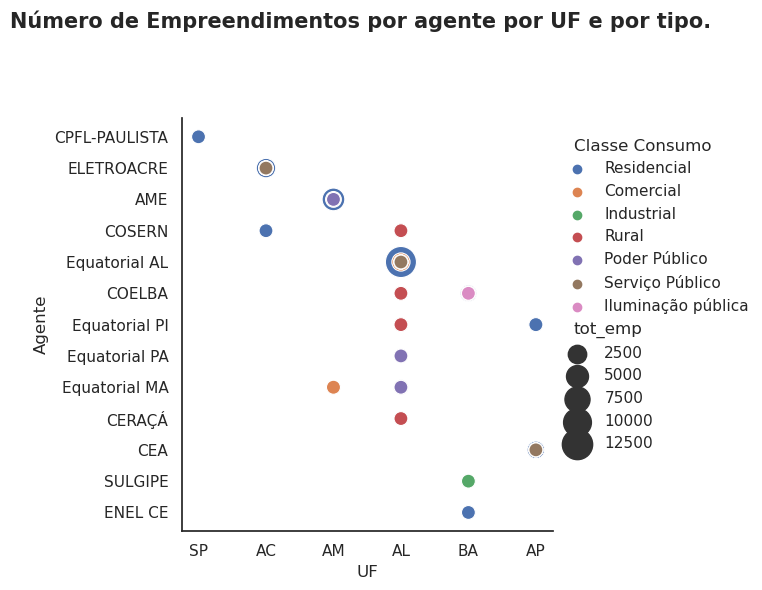

In [63]:
sns.set_theme(style="white")
sp = sns.relplot(x="UF",y='Agente',size='tot_emp',hue='Classe Consumo', alpha=1,sizes=(100, 500),
            height=6,data=df4)
sp.fig.subplots_adjust(top=0.8)
sp.fig.suptitle("Número de Empreendimentos por agente por UF e por tipo.", fontweight="bold", fontsize=15)